In [5]:
import os
import tensorflow as tf
from util import constants
from util.config_util import get_model_params, get_task_params, get_train_params
from tf2_models.trainer import Trainer
from absl import app
from absl import flags
import numpy as np
from util.models import MODELS
from util.tasks import TASKS
import tensorflow_probability as tfp

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns; sns.set()
sns.set_style("whitegrid")

from tqdm import tqdm



In [6]:
chkpt_dir='../tf_ckpts'
task_name = 'mnist'
task = TASKS[task_name](get_task_params(), data_dir='../data')

model config: vcnn_lenet5
{'hidden_dim': [120, 84], 'depth': 2, 'proj_depth': 2, 'filters': [6, 16], 'kernel_size': [(3, 3), (3, 3), (3, 3)], 'pool_size': [(2, 2), (2, 2), (2, 2)], 'hidden_dropout_rate': 0.5, 'input_dropout_rate': 0.2}
student_checkpoint: ../tf_ckpts/mnist/cl_vcnn_h-120.84_d-2_hdrop-0.5_indrop-0.2_vcnn_lenet5_0.001_mnisttrial4
Restored student from ../tf_ckpts/mnist/cl_vcnn_h-120.84_d-2_hdrop-0.5_indrop-0.2_vcnn_lenet5_0.001_mnisttrial4/ckpt-20
100/100 [==============================] - 1s 6ms/step - loss: 0.0710 - classification_loss: 0.0710 - sparse_categorical_accuracy: 0.9853
9984
9984


/home/samira/anaconda3/envs/indist/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


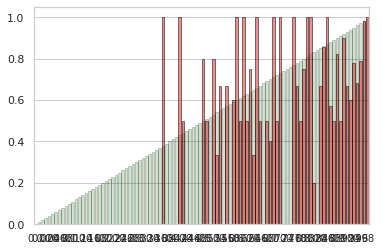

0.014480602


In [33]:
exp_name = '0.001_mnisttrial4'
model_name = 'cl_vcnn'
model_config = 'vcnn_lenet5'
model_params = get_model_params(task, model_name, model_config)
model_params.output_attentions = True
model_params.output_embeddings = True
model = MODELS[model_name](hparams=model_params)

ckpt_dir = os.path.join(chkpt_dir, 'mnist',
                          '_'.join([
                                    model.model_name,
                                    str(model_config),
                                    exp_name]))
print("student_checkpoint:", ckpt_dir)

ckpt = tf.train.Checkpoint(net=model)
manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=None)

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored student from {}".format(manager.latest_checkpoint))
else:
  print("Initialized  from scratch!")

model.compile(loss=task.get_loss_fn(), metrics=task.metrics())
model.evaluate(task.test_dataset, steps=100)

model_accuracy, predicted_class_probs, correct_class_probs, model_logits, model_trues= test_for_calibration(model, task, n_bins=20)

print(len(model_accuracy))
print(len(predicted_class_probs))
plot_calibration(model_accuracy, predicted_class_probs, correct_class_probs, n_bins=100)
plt.savefig('cl_bertv10_calibrarion.png', format='png', dpi=360)
plt.show()
model_ece = tfp.stats.expected_calibration_error(
    1000000,
    logits=model_logits,
    labels_true=model_trues,
)
print(model_ece.numpy())


model config: ff_mnist
{'hidden_dim': 128, 'depth': 3, 'hidden_dropout_rate': 0.5, 'input_dropout_rate': 0.2}
student_checkpoint: ../tf_ckpts/mnist/cl_vff_h-128_d-3_hdrop-0.5_indrop-0.2_ff_mnist_0.001_mnisttrial2
Restored student from ../tf_ckpts/mnist/cl_vff_h-128_d-3_hdrop-0.5_indrop-0.2_ff_mnist_0.001_mnisttrial2/ckpt-20
100/100 [==============================] - 1s 6ms/step - loss: 0.1409 - classification_loss: 0.1409 - sparse_categorical_accuracy: 0.9722
9984
9984


/home/samira/anaconda3/envs/indist/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


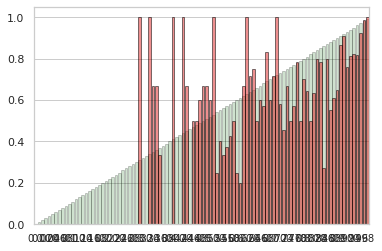

0.028961245


In [34]:
exp_name = '0.001_mnisttrial2'
model_name = 'cl_vff'
model_config = 'ff_mnist'
model_params = get_model_params(task, model_name, model_config)
model_params.output_attentions = True
model_params.output_embeddings = True
model = MODELS[model_name](hparams=model_params)

ckpt_dir = os.path.join(chkpt_dir, 'mnist',
                          '_'.join([
                                    model.model_name,
                                    str(model_config),
                                    exp_name]))
print("student_checkpoint:", ckpt_dir)

ckpt = tf.train.Checkpoint(net=model)
manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=None)

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored student from {}".format(manager.latest_checkpoint))
else:
  print("Initialized  from scratch!")

model.compile(loss=task.get_loss_fn(), metrics=task.metrics())
model.evaluate(task.test_dataset, steps=100)

model_accuracy, predicted_class_probs, correct_class_probs, model_logits, model_trues= test_for_calibration(model, task, n_bins=20)

print(len(model_accuracy))
print(len(predicted_class_probs))
plot_calibration(model_accuracy, predicted_class_probs, correct_class_probs, n_bins=100)
plt.savefig('cl_bertv10_calibrarion.png', format='png', dpi=360)
plt.show()
model_ece = tfp.stats.expected_calibration_error(
    1000000,
    logits=model_logits,
    labels_true=model_trues,
)
print(model_ece.numpy())

In [ ]:
exp_name = '0.001_mnisttrial'
model_name = 'cl_vcnn'
model_config = 'vcnn_mnist'
model_params = get_model_params(task, model_name, model_config)
model_params.output_attentions = True
model_params.output_embeddings = True
model = MODELS[model_name](hparams=model_params)

ckpt_dir = os.path.join(chkpt_dir, 'mnis',
                          '_'.join([
                                    model.model_name,
                                    str(model_config),
                                    exp_name]))
print("student_checkpoint:", ckpt_dir)

ckpt = tf.train.Checkpoint(net=model)
manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=None)

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored student from {}".format(manager.latest_checkpoint))
else:
  print("Initialized  from scratch!")

model.compile(loss=task.get_loss_fn(), metrics=task.metrics())
model.evaluate(task.test_dataset, steps=100)

model_accuracy, predicted_class_probs, correct_class_probs, model_logits, model_trues= test_for_calibration(model, task, n_bins=20)

print(len(model_accuracy))
print(len(predicted_class_probs))
plot_calibration(model_accuracy, predicted_class_probs, correct_class_probs, n_bins=20)
plt.savefig('cl_bertv10_calibrarion.png', format='png', dpi=360)
plt.show()
model_ece = tfp.stats.expected_calibration_error(
    1000000,
    logits=model_logits,
    labels_true=model_trues,
)
print(model_ece.numpy())

In [4]:
def test_for_calibration(model, task, n_bins=10):
    preds = []
    correct_class_probs = []
    predicted_class_probs = []
    pred_logits = []
    y_trues = []
    batch_count = task.n_valid_batches
    for x, y in task.valid_dataset:
        logits = model(x)
        pred_logits.extend(logits.numpy())
        pred = tf.argmax(logits, axis=-1)
        prob = task.get_probs_fn()(logits, labels=y, temperature=1)
        preds.extend(pred.numpy())
        y_trues.extend(y.numpy())
        batch_indexes = tf.cast(tf.range(len(y), dtype=tf.int32), dtype=tf.int32)
        true_indexes = tf.concat([batch_indexes[:,None], y[:,None]], axis=1)
        pred_indexes = tf.concat([batch_indexes[:,None], tf.cast(pred[:,None], tf.int32)], axis=1)

        correct_class_probs.extend(tf.gather_nd(prob, true_indexes).numpy())
        predicted_class_probs.extend(tf.gather_nd(prob, pred_indexes).numpy())

        batch_count -= 1
        if batch_count == 0:
            break

    model_accuracy = np.asarray(preds) == np.asarray(y_trues)

    return model_accuracy, predicted_class_probs, correct_class_probs, pred_logits, y_trues

def plot_calibration(model_accuracy, predicted_class_probs, correct_class_probs, n_bins=10):
    p_confidence_bins = np.zeros(n_bins+1)
    n_confidence_bins = np.zeros(n_bins+1)
    total_confidence_bins = np.zeros(n_bins+1)
    
    denominator = 100.0 / n_bins
    for i in np.arange(len(model_accuracy)):
        if model_accuracy[i]:
            p_confidence_bins[int(predicted_class_probs[i]*100 / denominator)] += 1.0
        else:
            n_confidence_bins[int(predicted_class_probs[i]*100 / denominator)] -= 1.0
        total_confidence_bins[int(predicted_class_probs[i]*100 / denominator)] += 1

    #sns.stripplot(model_accuracy,predicted_class_probs, color='blue', alpha=0.5, jitter=True)
    #sns.stripplot(model_accuracy,correct_class_probs, color='green', alpha=0.2, jitter=True)
    #sns.swarmplot(model_accuracy,predicted_class_probs, color='blue', alpha=0.5)
    #plt.show()
   
    sns.barplot(x=np.arange(0,n_bins)*denominator, 
                y=np.arange(0,n_bins)/n_bins, 
                color='green', alpha=0.2, edgecolor='black')
    ax = sns.barplot(x=np.arange(0,n_bins)*denominator, 
                    y=p_confidence_bins[1:]/total_confidence_bins[1:], 
                    color='red', alpha=0.5, edgecolor='black')
    
    x_ticks = np.arange(0,n_bins,2)
    x_tick_labels = x_ticks / np.float32(n_bins)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_tick_labels, fontsize=10)
    
def expected_calibration_error(teacher_accuracy, teacher_predicted_class_probs):
    raise NotImplemented

In [ ]:
teacher_accuracy, teacher_predicted_class_probs, teacher_correct_class_probs, teacher_logits, teacher_trues = test_for_calibration(teacher_model, task, n_bins=20)

In [ ]:
plot_calibration(teacher_accuracy, teacher_predicted_class_probs, teacher_correct_class_probs, n_bins=20)
plt.savefig('cl_lstm_v11_calibrarion.png', format='png', dpi=360)
plt.show()

In [ ]:
teacher_ece = tfp.stats.expected_calibration_error(
    1000000,
    logits=teacher_logits,
    labels_true=teacher_trues,
)
print(teacher_ece.numpy())

In [ ]:
student_accuracy, student_predicted_class_probs, student_correct_class_probs, std_logits, std_trues = test_for_calibration(student_model, task, n_bins=20)

In [ ]:
std_ece = tfp.stats.expected_calibration_error(
    1000000,
    logits=std_logits,
    labels_true=std_trues,
)
print(std_ece.numpy())

In [ ]:
plot_calibration(student_accuracy, student_predicted_class_probs, student_correct_class_probs, n_bins=20)
plt.savefig('cl_bert_L11toB_calibrarion.png', format='png', dpi=360)
plt.show()

In [ ]:
task_name = 'word_sv_agreement_vp'
model_name='cl_bert'
model_config='small_gpt_v9'
learning_rate=0.001
exp_name='samira_offlineteacher_v10'

# model_name='cl_lstm'
# model_config='small_lstm_v4'
# learning_rate=0.001
# exp_name='samira_offlineteacher_v10'

task = TASKS[task_name](get_task_params(), data_dir='../data') 

cl_token = task.databuilder.sentence_encoder().encode(constants.bos)
hparams=get_model_params(task, model_name, model_config)
hparams.output_attentions = True
hparams.output_embeddings = True

model = MODELS[model_name](hparams=hparams, cl_token=cl_token)


ckpt_dir = os.path.join(chkpt_dir,task.name,
                        model.model_name+"_"+str(model_config)+"_"+str(learning_rate)+"_"+exp_name)

ckpt = tf.train.Checkpoint(net=model)
manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=None)

ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored student from {}".format(manager.latest_checkpoint))

model.compile(loss=task.get_loss_fn(), metrics=task.metrics())
model.evaluate(task.test_dataset, steps=100)

In [ ]:
from notebook_utils import *
config = {'student_exp_name':'lisa_fd220',
        'teacher_exp_name':'0.001_samira_offlineteacher_v11',
        'teacher_config':'small_gpt_v9',
        'student_model':'cl_bert',
        'teacher_model':'cl_gpt2',
        'student_config':'small_gpt_v9',
        'distill_config':'pure_dstl_4_crs_slw',
        'distill_mode':'offline',
        'chkpt_dir':'../tf_ckpts',}
                
std_hparams=get_model_params(task, config['student_model'], config['student_config'])
           
print(get_student_model(task, std_hparams, cl_token, config, return_ckpnt=True))
config = {'student_exp_name':'lisa_fd226',
        'teacher_exp_name':'0.001_samira_offlineteacher_v5',
        'teacher_config':'small_gpt_v9',
        'student_model':'cl_bert',
        'teacher_model':'cl_gpt2',
        'student_config':'small_gpt_v9',
        'distill_config':'pure_dstl_4_crs_slw',
        'distill_mode':'offline',
        'chkpt_dir':'../tf_ckpts',}
                
std_hparams=get_model_params(task, config['student_model'], config['student_config'])
           
print(get_student_model(task, std_hparams, cl_token, config, return_ckpnt=True))
config = {'student_exp_name':'lisa_fd225',
        'teacher_exp_name':'0.001_samira_offlineteacher_v5',
        'teacher_config':'small_gpt_v9',
        'student_model':'cl_bert',
        'teacher_model':'cl_gpt2',
        'student_config':'small_gpt_v9',
        'distill_config':'pure_dstl_4_crs_slw',
        'distill_mode':'offline',
        'chkpt_dir':'../tf_ckpts',}
                
std_hparams=get_model_params(task, config['student_model'], config['student_config'])
           
print(get_student_model(task, std_hparams, cl_token, config, return_ckpnt=True))